In [5]:
import os
import sys
from pycocotools.coco import COCO

# initialize COCO API for instance annotations
dataDir = '/opt/cocoapi'
dataType = 'val2014'
instances_annFile = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/instances_train2014.json'
coco = COCO(instances_annFile)

# initialize COCO API for caption annotations
captions_annFile = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json'
coco_caps = COCO(captions_annFile)

# get image ids 
ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=19.02s)
creating index...
index created!
loading annotations into memory...
Done (t=1.89s)
creating index...
index created!


http://images.cocodataset.org/train2014/COCO_train2014_000000567858.jpg


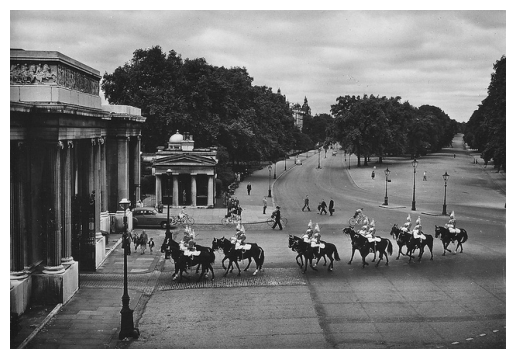

A parade of riders on horses is marching towards to building.
Several rows of people riding horses towards a columned building. 
A parade of horses crosses the empty road
Pairs of horses being rode by people in uniforms approaching a building from the street.
Back and white photo of riders on horseback riding two by two.


In [6]:
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

# data loader 

In [7]:
import nltk
import pickle
from collections import Counter

In [8]:
class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        annotations_file='../cocoapi/annotations/captions_train2014.json',
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.annotations_file = annotations_file
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        else:
            self.build_vocab()
            with open(self.vocab_file, 'wb') as f:
                pickle.dump(self, f)
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [9]:
import torch
import torch.utils.data as data
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json

/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/instances_val2017.json
/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/instances_train2017.json
/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/person_keypoints_val2017.json
/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_train2017.json
/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json
/kaggle/input/coco-image-caption/val2017/val2017/


/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/instances_train2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/instances_val2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/person_keypoints_val2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/person_keypoints_train2014.json
/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_val2014.json
/kaggle/input/coco-image-caption/train2014/train2014/

In [10]:
def get_loader(transform,
               mode='train',
               batch_size=1,
               vocab_threshold=None,
               vocab_file='./vocab.pkl',
               start_word="<start>",
               end_word="<end>",
               unk_word="<unk>",
               vocab_from_file=True,
               num_workers=0):
    """Returns the data loader.
    Args:
      transform: Image transform.
      mode: One of 'train' or 'test'.
      batch_size: Batch size (if in testing mode, must have batch_size=1).
      vocab_threshold: Minimum word count threshold.
      vocab_file: File containing the vocabulary. 
      start_word: Special word denoting sentence start.
      end_word: Special word denoting sentence end.
      unk_word: Special word denoting unknown words.
      vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
                       If True, load vocab from from existing vocab_file, if it exists.
      num_workers: Number of subprocesses to use for data loading 
      cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
    """
    
    assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
    if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

    # Based on mode (train, val, test), obtain img_folder and annotations_file.
    if mode == 'train':
        if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
        img_folder = '/kaggle/input/coco-image-caption/train2014/train2014/'
        annotations_file = '/kaggle/input/coco-image-caption/annotations_trainval2014/annotations/captions_train2014.json'
    if mode == 'test':
        assert batch_size==1, "Please change batch_size to 1 if testing your model."
        assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
        assert vocab_from_file==True, "Change vocab_from_file to True."
        img_folder = '/kaggle/input/coco-image-caption/val2017/val2017/'
        annotations_file = '/kaggle/input/coco-image-caption/annotations_trainval2017/annotations/captions_val2017.json'

    # COCO caption dataset.
    dataset = CoCoDataset(transform=transform,
                          mode=mode,
                          batch_size=batch_size,
                          vocab_threshold=vocab_threshold,
                          vocab_file=vocab_file,
                          start_word=start_word,
                          end_word=end_word,
                          unk_word=unk_word,
                          annotations_file=annotations_file,
                          vocab_from_file=vocab_from_file,
                          img_folder=img_folder)

    if mode == 'train':
        # Randomly sample a caption length, and sample indices with that length.
        indices = dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        # data loader for COCO dataset.
        data_loader = data.DataLoader(dataset=dataset, 
                                      num_workers=num_workers,
                                      batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                              batch_size=dataset.batch_size,
                                                                              drop_last=False))
    else:
        data_loader = data.DataLoader(dataset=dataset,
                                      batch_size=dataset.batch_size,
                                      shuffle=True,
                                      num_workers=num_workers)

    return data_loader

class CoCoDataset(data.Dataset):
    
    def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
        end_word, unk_word, annotations_file, vocab_from_file, img_folder):
        self.transform = transform
        self.mode = mode
        self.batch_size = batch_size
        self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
            end_word, unk_word, annotations_file, vocab_from_file)
        self.img_folder = img_folder
        if self.mode == 'train':
            self.coco = COCO(annotations_file)
            n = 15000 # number of data used for training
#             self.coco = np.random.choice(self.coco, n)
            self.ids = list(self.coco.anns.keys())
            self.ids = np.random.choice(self.ids, n)
            print('Obtaining caption lengths...')
            all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
            self.caption_lengths = [len(token) for token in all_tokens]
        else:
            test_info = json.loads(open(annotations_file).read())
            self.paths = [item['file_name'] for item in test_info['images']]
        
    def __getitem__(self, index):
        # obtain image and caption if in training mode
        if self.mode == 'train':
            ann_id = self.ids[index]
            caption = self.coco.anns[ann_id]['caption']
            img_id = self.coco.anns[ann_id]['image_id']
            path = self.coco.loadImgs(img_id)[0]['file_name']

            # Convert image to tensor and pre-process using transform
            image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)

            # Convert caption to tensor of word ids.
            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(self.vocab(self.vocab.start_word))
            caption.extend([self.vocab(token) for token in tokens])
            caption.append(self.vocab(self.vocab.end_word))
            caption = torch.Tensor(caption).long()

            # return pre-processed image and caption tensors
            return image, caption

        # obtain image if in test mode
        else:
            path = self.paths[index]

            # Convert image to tensor and pre-process using transform
            PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            orig_image = np.array(PIL_image)
            image = self.transform(PIL_image)

            # return original image and pre-processed image tensor
            return orig_image, image

    def get_train_indices(self):
        sel_length = np.random.choice(self.caption_lengths)
        all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
        indices = list(np.random.choice(all_indices, size=self.batch_size))
        return indices

    def __len__(self):
        if self.mode == 'train':
            return len(self.ids)
        else:
            return len(self.paths)

# 2-training 

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models


class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # pretrained model resnet50
        resnet = models.resnet50(pretrained=True)
        
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # replace the classifier with a fully connected embedding layer
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size, 
                            self.hidden_size, 
                            self.num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
#         self.hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
    
    def forward(self, features, captions):
        
        caption_embed = self.word_embedding(captions[:, :-1])
        caption_embed = torch.cat((features.unsqueeze(dim=1), caption_embed),1)
        output, self.hidden = self.lstm(caption_embed)
#         print(output.shape)
        output = self.fc(output)
#         print(self.embed_size, self.vocab_size)
        return output

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        """Samples captions for given image features."""
        output = []
        (h, c) = (torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device), torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device))
        for i in range(max_len):
            x, (h, c) = self.lstm(inputs, (h, c))
            x = self.fc(x)
            x = x.squeeze(1)
            predict = x.argmax(dim=1)
            if predict.item() == 1:
                break
            output.append(predict.item())
            inputs = self.word_embedding(predict.unsqueeze(0))
        return output

In [12]:
from torchvision import transforms
import sys
import math


## Select appropriate values for the Python variables below.
batch_size = 10          # batch size
vocab_threshold = 4        # minimum word count threshold
vocab_from_file = False     # if True, load existing vocab file
embed_size = 256           # dimensionality of image and word embeddings
hidden_size = 512          # number of features in hidden state of the RNN decoder
num_epochs = 5             # number of training epochs
save_every = 5            # determines frequency of saving model weights
print_every = 150          # determines window for printing average loss
log_file = 'training_log.txt'       # name of file with saved training loss and perplexity

# (Optional)  Amend the image transform below.
transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

# Build data loader.
data_loader = get_loader(transform=transform_train,
                         mode='train',
                         batch_size=batch_size,
                         vocab_threshold=vocab_threshold,
                         vocab_from_file=vocab_from_file)

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder. 
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
encoder.to(device)
decoder.to(device)

# Define the loss function. 
criterion = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters())+list(encoder.embed.parameters())

# Define the optimizer.
optimizer = torch.optim.Adam(params,lr=0.0005)

# Set the total number of training steps per epoch.
total_step = math.ceil(len(data_loader.dataset.caption_lengths) / data_loader.batch_sampler.batch_size)

loading annotations into memory...
Done (t=1.08s)
creating index...
index created!
[0/414113] Tokenizing captions...
[100000/414113] Tokenizing captions...
[200000/414113] Tokenizing captions...
[300000/414113] Tokenizing captions...
[400000/414113] Tokenizing captions...
loading annotations into memory...
Done (t=1.05s)
creating index...
index created!
Obtaining caption lengths...


100%|██████████| 15000/15000 [00:02<00:00, 5471.91it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 142MB/s] 


cuda


Epoch [1/5], Step [150/1500], Loss: 3.9539, Perplexity: 52.13979
Epoch [1/5], Step [300/1500], Loss: 3.7042, Perplexity: 40.61585
Epoch [1/5], Step [450/1500], Loss: 3.9932, Perplexity: 54.22931
Epoch [1/5], Step [600/1500], Loss: 3.9640, Perplexity: 52.66585
Epoch [1/5], Step [750/1500], Loss: 3.8226, Perplexity: 45.72215
Epoch [1/5], Step [900/1500], Loss: 3.4596, Perplexity: 31.80553
Epoch [1/5], Step [1050/1500], Loss: 3.7219, Perplexity: 41.3428
Epoch [1/5], Step [1200/1500], Loss: 3.5181, Perplexity: 33.7218
Epoch [1/5], Step [1350/1500], Loss: 2.6694, Perplexity: 14.43123
Epoch [1/5], Step [1500/1500], Loss: 3.0956, Perplexity: 22.0996
Epoch [2/5], Step [150/1500], Loss: 3.1572, Perplexity: 23.50413
Epoch [2/5], Step [300/1500], Loss: 3.1879, Perplexity: 24.2381
Epoch [2/5], Step [450/1500], Loss: 3.2088, Perplexity: 24.7500
Epoch [2/5], Step [600/1500], Loss: 2.7879, Perplexity: 16.2462
Epoch [2/5], Step [750/1500], Loss: 2.7325, Perplexity: 15.3717
Epoch [2/5], Step [900/1500]

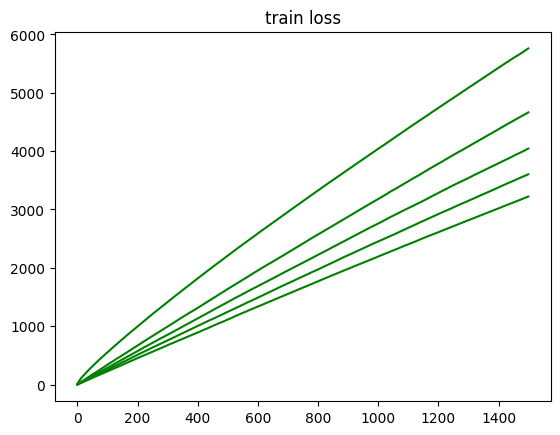

In [13]:
import torch.utils.data as data
import requests
import time

# Open the training log file.
# f = open(log_file, 'w')

# old_time = time.time()
# response = requests.request("GET", 
#                             "http://metadata.google.internal/computeMetadata/v1/instance/attributes/keep_alive_token", 
#                             headers={"Metadata-Flavor":"Google"})

for epoch in range(1, num_epochs+1):
    
    running_loss = 0.0
    loss_values = []
    
    for i_step in range(1, total_step+1):
        
        
        # Randomly sample a caption length, and sample indices with that length.
        indices = data_loader.dataset.get_train_indices()
        # Create and assign a batch sampler to retrieve a batch with the sampled indices.
        new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
        data_loader.batch_sampler.sampler = new_sampler
        
        # Obtain the batch.
        images, captions = next(iter(data_loader))

        # Move batch of images and captions to GPU if CUDA is available.
        images = images.to(device)
        captions = captions.to(device)
        
        # Zero the gradients.
        decoder.zero_grad()
        encoder.zero_grad()
        
        # Pass the inputs through the CNN-RNN model.
        features = encoder(images)
        outputs = decoder(features, captions)
        
        # Calculate the batch loss.
        loss = criterion(outputs.view(-1, vocab_size), captions.view(-1))
        
        # Backward pass.
        loss.backward()
        
        # Update the parameters in the optimizer.
        optimizer.step()
            
        # Get training statistics.
        stats = 'Epoch [%d/%d], Step [%d/%d], Loss: %.4f, Perplexity: %5.4f' % (epoch, num_epochs, i_step, total_step, loss.item(), np.exp(loss.item()))
        
        # Print training statistics (on same line).
        print('\r' + stats, end="")
        sys.stdout.flush()
        
        
        # Print training statistics (on different line).
        if i_step % print_every == 0:
            print('\r' + stats)
            
        running_loss += loss.item()
        loss_values.append(running_loss)
        
    # plotting loss    
    plt.plot(np.array(loss_values), 'g')
    plt.title('train loss')
            
    # Save the weights.
    if epoch % save_every == 0:
        torch.save(decoder.state_dict(), 'decoder-%d.pkl' % epoch)
        torch.save(encoder.state_dict(), 'encoder-%d.pkl' % epoch)


Text(0.5, 1.0, 'Train loss')

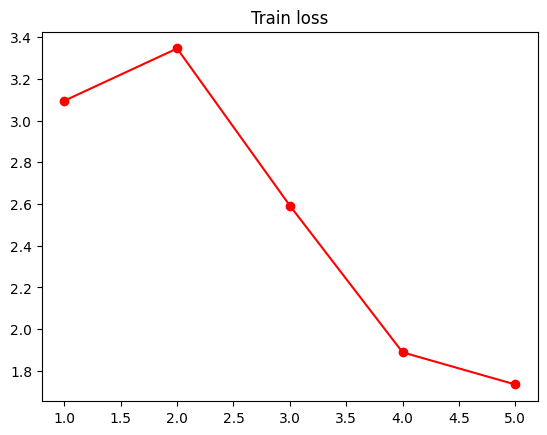

In [39]:
plt.plot([1, 2 , 3, 4, 5], [3.0956, 3.3463, 2.5924, 1.8884, 1.7341], '-o', color = 'r')
plt.title('Train loss')

# Testing 

In [14]:
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


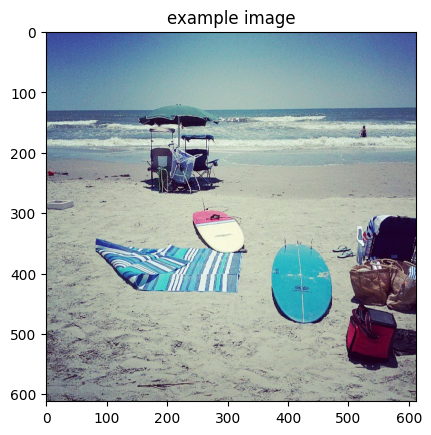

In [15]:
# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda')

In [17]:
% load_ext autoreload
% autoreload 2

# Specify the saved models to load.
encoder_file = 'encoder-5.pkl' 
decoder_file = 'decoder-5.pkl'

# Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(encoder_file))
decoder.load_state_dict(torch.load(decoder_file))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

UsageError: Line magic function `%` not found.


In [18]:
vocab_size

9955

In [19]:
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 60, 6, 20, 26, 13, 3, 169, 139, 3, 755, 18]


In [20]:
def clean_sentence(output):
    cleaned_list = []
    for index in output:
        if  (index == 1) :
            continue
        cleaned_list.append(data_loader.dataset.vocab.idx2word[index])
    cleaned_list = cleaned_list[1:-1] # Discard <start> and <end> 

    sentence = ' '.join(cleaned_list) # Convert list of string to                                                    
    sentence = sentence.capitalize()    
    return sentence

In [21]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: A black and white photo of a man riding a skateboard


In [24]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

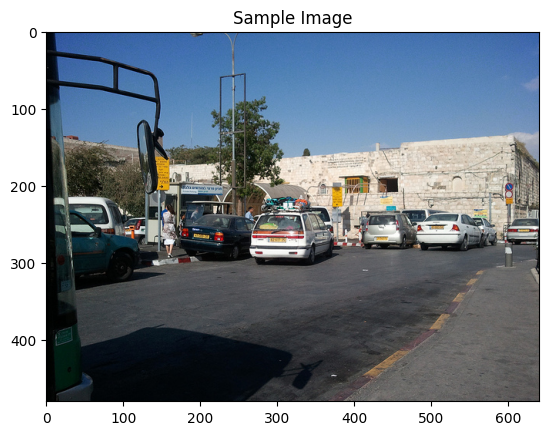

A person sitting on a bench with a dog on the back


In [46]:
get_prediction()

In [ ]:
from PIL import Image
import torch 

def generate_caption(image):
    
    # Specify the saved models to load.
    encoder_file = 'encoder-5.pkl' 
    decoder_file = 'decoder-5.pkl'

    # Select appropriate values for the Python variables below.
    embed_size = 256
    hidden_size = 512

    # The size of the vocabulary.
    vocab_size = len(data_loader.dataset.vocab)

    # Initialize the encoder and decoder, and set each to inference mode.
    encoder = EncoderCNN(embed_size)
    encoder.eval()
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
    decoder.eval()

    # Load the trained weights.
    encoder.load_state_dict(torch.load(encoder_file))
    decoder.load_state_dict(torch.load(decoder_file))

    # Move models to GPU if CUDA is available.
    encoder.to(device)
    decoder.to(device)
    
    # set the transformer for feeding image to encoder
    transform_train = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
    
    image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
            image = self.transform(image)
    
    

In [73]:
vocab_size

9955

enter the path:



 /kaggle/input/coco-image-caption/train2014/train2014/COCO_train2014_000000000009.jpg


cuda


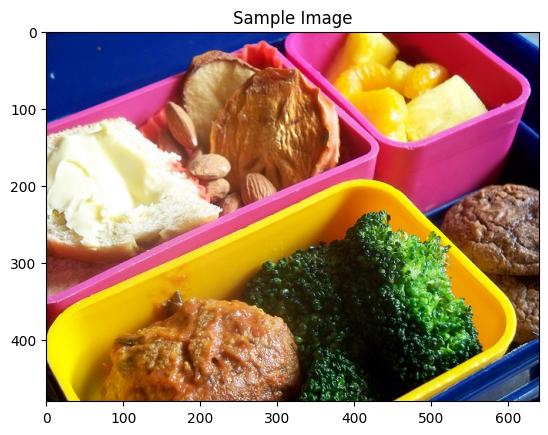

Vocabulary successfully loaded from vocab.pkl file!
A man is standing on a table with a large umbrella


In [79]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from PIL import Image
import matplotlib.pylab as plt
import nltk
import os
import torch.utils.data as data
from pycocotools.coco import COCO
import numpy as np
from tqdm import tqdm
import json
import pickle
import os.path
from collections import Counter

class Vocabulary(object):

    def __init__(self,
        vocab_threshold,
        vocab_file='./vocab.pkl',
        start_word="<start>",
        end_word="<end>",
        unk_word="<unk>",
        vocab_from_file=False):
        """Initialize the vocabulary.
        Args:
          vocab_threshold: Minimum word count threshold.
          vocab_file: File containing the vocabulary.
          start_word: Special word denoting sentence start.
          end_word: Special word denoting sentence end.
          unk_word: Special word denoting unknown words.
          annotations_file: Path for train annotation file.
          vocab_from_file: If False, create vocab from scratch & override any existing vocab_file
                           If True, load vocab from from existing vocab_file, if it exists
        """
        self.vocab_threshold = vocab_threshold
        self.vocab_file = vocab_file
        self.start_word = start_word
        self.end_word = end_word
        self.unk_word = unk_word
        self.vocab_from_file = vocab_from_file
        self.get_vocab()

    def get_vocab(self):
        """Load the vocabulary from file OR build the vocabulary from scratch."""
        if os.path.exists(self.vocab_file) & self.vocab_from_file:
            with open(self.vocab_file, 'rb') as f:
                vocab = pickle.load(f)
                self.word2idx = vocab.word2idx
                self.idx2word = vocab.idx2word
            print('Vocabulary successfully loaded from vocab.pkl file!')
        
    def build_vocab(self):
        """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
        self.init_vocab()
        self.add_word(self.start_word)
        self.add_word(self.end_word)
        self.add_word(self.unk_word)
        self.add_captions()

    def init_vocab(self):
        """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        """Add a token to the vocabulary."""
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def add_captions(self):
        """Loop over training captions and add all tokens to the vocabulary that meet or exceed the threshold."""
        coco = COCO(self.annotations_file)
        counter = Counter()
        ids = coco.anns.keys()
        for i, id in enumerate(ids):
            caption = str(coco.anns[id]['caption'])
            tokens = nltk.tokenize.word_tokenize(caption.lower())
            counter.update(tokens)

            if i % 100000 == 0:
                print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

        words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

        for i, word in enumerate(words):
            self.add_word(word)

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx[self.unk_word]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

# def get_loader(transform,
#                mode='train',
#                batch_size=1,
#                vocab_threshold=None,
#                vocab_file='./vocab.pkl',
#                start_word="<start>",
#                end_word="<end>",
#                unk_word="<unk>",
#                vocab_from_file=True,
#                num_workers=0,
#                cocoapi_loc='/opt'):
#     """Returns the data loader.
#     Args:
#       transform: Image transform.
#       mode: One of 'train' or 'test'.
#       batch_size: Batch size (if in testing mode, must have batch_size=1).
#       vocab_threshold: Minimum word count threshold.
#       vocab_file: File containing the vocabulary. 
#       start_word: Special word denoting sentence start.
#       end_word: Special word denoting sentence end.
#       unk_word: Special word denoting unknown words.
#       vocab_from_file: If False, create vocab from scratch & override any existing vocab_file.
#                        If True, load vocab from from existing vocab_file, if it exists.
#       num_workers: Number of subprocesses to use for data loading 
#       cocoapi_loc: The location of the folder containing the COCO API: https://github.com/cocodataset/cocoapi
#     """
    
#     assert mode in ['train', 'test'], "mode must be one of 'train' or 'test'."
#     if vocab_from_file==False: assert mode=='train', "To generate vocab from captions file, must be in training mode (mode='train')."

#     # Based on mode (train, val, test), obtain img_folder and annotations_file.
#     if mode == 'train':
#         if vocab_from_file==True: assert os.path.exists(vocab_file), "vocab_file does not exist.  Change vocab_from_file to False to create vocab_file."
#         img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/train2014/')
#         annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/captions_train2014.json')
#     if mode == 'test':
#         assert batch_size==1, "Please change batch_size to 1 if testing your model."
#         assert os.path.exists(vocab_file), "Must first generate vocab.pkl from training data."
#         assert vocab_from_file==True, "Change vocab_from_file to True."
#         img_folder = os.path.join(cocoapi_loc, 'cocoapi/images/test2014/')
#         annotations_file = os.path.join(cocoapi_loc, 'cocoapi/annotations/image_info_test2014.json')

#     # COCO caption dataset.
#     dataset = CoCoDataset(transform=transform,
#                           mode=mode,
#                           batch_size=batch_size,
#                           vocab_threshold=vocab_threshold,
#                           vocab_file=vocab_file,
#                           start_word=start_word,
#                           end_word=end_word,
#                           unk_word=unk_word,
#                           annotations_file=annotations_file,
#                           vocab_from_file=vocab_from_file,
#                           img_folder=img_folder)

#     if mode == 'train':
#         # Randomly sample a caption length, and sample indices with that length.
#         indices = dataset.get_train_indices()
#         # Create and assign a batch sampler to retrieve a batch with the sampled indices.
#         initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
#         # data loader for COCO dataset.
#         data_loader = data.DataLoader(dataset=dataset, 
#                                       num_workers=num_workers,
#                                       batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
#                                                                               batch_size=dataset.batch_size,
#                                                                               drop_last=False))
#     else:
#         data_loader = data.DataLoader(dataset=dataset,
#                                       batch_size=dataset.batch_size,
#                                       shuffle=True,
#                                       num_workers=num_workers)

#     return data_loader

# class CoCoDataset(data.Dataset):
    
#     def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, 
#         end_word, unk_word, annotations_file, vocab_from_file, img_folder):
#         self.transform = transform
#         self.mode = mode
#         self.batch_size = batch_size
#         self.vocab = Vocabulary(vocab_threshold, vocab_file, start_word,
#             end_word, unk_word, annotations_file, vocab_from_file)
#         self.img_folder = img_folder
#         if self.mode == 'train':
#             self.coco = COCO(annotations_file)
#             self.ids = list(self.coco.anns.keys())
#             print('Obtaining caption lengths...')
#             all_tokens = [nltk.tokenize.word_tokenize(str(self.coco.anns[self.ids[index]]['caption']).lower()) for index in tqdm(np.arange(len(self.ids)))]
#             self.caption_lengths = [len(token) for token in all_tokens]
#         else:
#             test_info = json.loads(open(annotations_file).read())
#             self.paths = [item['file_name'] for item in test_info['images']]
        
#     def __getitem__(self, index):
#         # obtain image and caption if in training mode
#         if self.mode == 'train':
#             ann_id = self.ids[index]
#             caption = self.coco.anns[ann_id]['caption']
#             img_id = self.coco.anns[ann_id]['image_id']
#             path = self.coco.loadImgs(img_id)[0]['file_name']

#             # Convert image to tensor and pre-process using transform
#             image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
#             image = self.transform(image)

#             # Convert caption to tensor of word ids.
#             tokens = nltk.tokenize.word_tokenize(str(caption).lower())
#             caption = []
#             caption.append(self.vocab(self.vocab.start_word))
#             caption.extend([self.vocab(token) for token in tokens])
#             caption.append(self.vocab(self.vocab.end_word))
#             caption = torch.Tensor(caption).long()

#             # return pre-processed image and caption tensors
#             return image, caption

#         # obtain image if in test mode
#         else:
#             path = self.paths[index]

#             # Convert image to tensor and pre-process using transform
#             PIL_image = Image.open(os.path.join(self.img_folder, path)).convert('RGB')
#             orig_image = np.array(PIL_image)
#             image = self.transform(PIL_image)

#             # return original image and pre-processed image tensor
#             return orig_image, image

#     def get_train_indices(self):
#         sel_length = np.random.choice(self.caption_lengths)
#         all_indices = np.where([self.caption_lengths[i] == sel_length for i in np.arange(len(self.caption_lengths))])[0]
#         indices = list(np.random.choice(all_indices, size=self.batch_size))
#         return indices

#     def __len__(self):
#         if self.mode == 'train':
#             return len(self.ids)
#         else:
#             return len(self.paths)

class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        # pretrained model resnet50
        resnet = models.resnet50(pretrained=True)
        
        for param in resnet.parameters():
            param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]
        self.resnet = nn.Sequential(*modules)
        # replace the classifier with a fully connected embedding layer
        self.embed = nn.Linear(resnet.fc.in_features, embed_size)

    def forward(self, images):
        features = self.resnet(images)
        features = features.view(features.size(0), -1)
        features = self.embed(features)
        return features
    

class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=2):
        super(DecoderRNN, self).__init__()
        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        
        self.word_embedding = nn.Embedding(self.vocab_size, self.embed_size)
        self.lstm = nn.LSTM(self.embed_size, 
                            self.hidden_size, 
                            self.num_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(self.hidden_size, self.vocab_size)
#         self.hidden = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))
        
    
    def forward(self, features, captions):
        
        caption_embed = self.word_embedding(captions[:, :-1])
        caption_embed = torch.cat((features.unsqueeze(dim=1), caption_embed),1)
        output, self.hidden = self.lstm(caption_embed)
#         print(output.shape)
        output = self.fc(output)
#         print(self.embed_size, self.vocab_size)
        return output

    def sample(self, inputs, states=None, max_len=20):
        " accepts pre-processed image tensor (inputs) and returns predicted sentence (list of tensor ids of length max_len) "
        
        """Samples captions for given image features."""
        output = []
        (h, c) = (torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device), torch.randn(self.num_layers, 1, self.hidden_size).to(inputs.device))
        for i in range(max_len):
            x, (h, c) = self.lstm(inputs, (h, c))
            x = self.fc(x)
            x = x.squeeze(1)
            predict = x.argmax(dim=1)
            if predict.item() == 1:
                break
            output.append(predict.item())
            inputs = self.word_embedding(predict.unsqueeze(0))
        return output



def clean_sentence(output):
    vocab_file='./vocab.pkl'
    start_word="<start>"
    end_word="<end>"
    unk_word="<unk>"
    vocab_from_file=True,
    vocab = Vocabulary(4, vocab_file, start_word,
            end_word, unk_word, vocab_from_file)
    cleaned_list = []
    for index in output:
        if  (index == 1) :
            continue
        cleaned_list.append(vocab.idx2word[index])
    cleaned_list = cleaned_list[1:-1] # Discard <start> and <end> 

    sentence = ' '.join(cleaned_list) # Convert list of string to                                                    
    sentence = sentence.capitalize()    
    return sentence

def generate_caption(image_path):


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # Specify the saved models to load.
    encoder_file = 'encoder-1.pkl'
    decoder_file = 'decoder-1.pkl'

    # Select appropriate values for the Python variables below.
    embed_size = 256
    hidden_size = 512

    # The size of the vocabulary.
    vocab_size = 9955

    # Initialize the encoder and decoder, and set each to inference mode.
    encoder = EncoderCNN(embed_size)
    encoder.eval()
    decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
    decoder.eval()

    # Load the trained weights.
    encoder.load_state_dict(torch.load(encoder_file))
    decoder.load_state_dict(torch.load(decoder_file))

    # Move models to GPU if CUDA is available.
    encoder.to(device)
    decoder.to(device)
    
    transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location
    transforms.RandomHorizontalFlip(),               # horizontally flip image with probability=0.5
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])
    
    PIL_image = Image.open(image_path).convert('RGB')
    orig_image = np.array(PIL_image)
    image = transform_test(PIL_image)
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image.unsqueeze(0)).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

def main():
    print('enter the path:\n')
    path = input()
    generate_caption(path)
main()